In [1]:
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


In [2]:

def decorated_histogram(fig, ax, data, bins=10, **kwargs):
    """
    Plot a histogram with custom decorations.
    
    Parameters:
    - data: array-like, the data to be histogrammed.
    - bins: int or sequence, the bin specification.
    - **kwargs: additional keyword arguments for plt.hist.
    """
    # Enable minor tick labels
    ax.minorticks_on()
    # Plot the histogram
    ax.hist(data, bins=bins, **kwargs)

    
    
    # Customize tick sizes and font sizes
    ax.tick_params(axis='both', which='major', direction='in', top=True, \
                   bottom=True, left=True, right=True, length=7, width=1.5, labelsize=14)
    ax.tick_params(axis='both', which='minor', direction='in', top=True, \
                   bottom=True, left=True, right=True, length=4, width=1, labelsize=10)

    # Enable grid with major and minor ticks
    #ax.grid(True, which='major', linestyle='-', linewidth='0.75', color='black')
    #ax.grid(True, which='minor', linestyle=':', linewidth='0.5', color='gray')

    # Set plot boundary thickness
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)

    # Add labels and title if provided
    if 'xlabel' in kwargs:
        ax.set_xlabel(kwargs['xlabel'])
    if 'ylabel' in kwargs:
        ax.set_ylabel(kwargs['ylabel'])
    if 'title' in kwargs:
        ax.set_title(kwargs['title'])
    return ax

In [3]:
# load catalog:
tt = Table.read(f'../data/CIV_healpix-dr1-cat-v1.fits', hdu="ABSORBER")
met_tt = Table.read(f'../data/CIV_healpix-dr1-cat-v1.fits', hdu="METADATA")

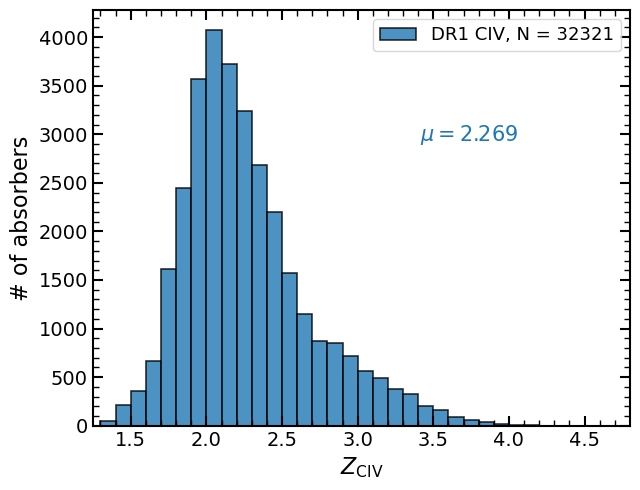

In [4]:
# Redshift Histograms

zciv = tt["Z_ABS"].data
kwargs = {'histtype':'stepfilled', 'color':'C0', 'lw':2, 'alpha':0.8, 'histtype':'bar', 'edgecolor':'black', 'linewidth':1.2, 'lw':2, 'density':False, 'label':f'DR1 CIV, N = {zciv.size}'}
fig = plt.figure(figsize=(6.5,5))
ax = fig.add_subplot(111)
ax = decorated_histogram(fig, ax , zciv, bins=np.arange(1.3, 4.8, 0.1), **kwargs)
ax.text(0.7, 0.7, "$\\mu = %.3f$"%(np.mean(zciv)), transform=ax.transAxes, fontsize=15, fontweight='bold', ha='center', va='center', color='C0')

ax.legend(prop={'size':13})
ax.set_xlabel('$Z_{\\rm CIV}$', fontsize=16)
ax.set_ylabel('# of absorbers', fontsize=16)
ax.set_xlim(1.25, 4.8)
#ax.set_yscale('log')
fig.tight_layout()
plt.show()

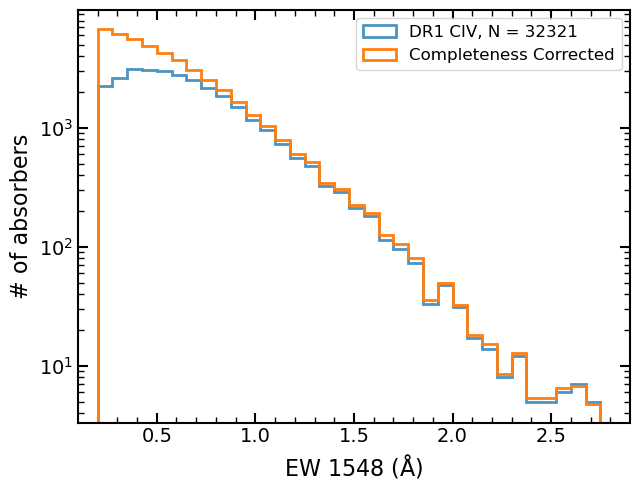

In [5]:
# EW histogram 

y = tt["CIV_1548_EW"].data
kwargs = {'histtype':'stepfilled', 'color':'C0', 'lw':2, 'alpha':0.8, 'histtype':'step', \
          'lw':2, 'density':False, 'label':f'DR1 CIV, N = {y.size}'}
fig = plt.figure(figsize=(6.5,5))
ax = fig.add_subplot(111)
ax = decorated_histogram(fig, ax, y, bins=np.arange(0.2, 2.8, 0.075), **kwargs)
ax.hist(y, bins=np.arange(0.2, 2.8, 0.075), label='Completeness Corrected', color='C1', alpha=1, \
        histtype='step', lw=2, density=False, weights=tt["CORRECTED_N"])
ax.legend(prop={'size':12})
ax.set_yscale('log')
ax.set_xlabel('EW 1548 ($\\rm \\AA$)', fontsize=16)
ax.set_ylabel('# of absorbers', fontsize=16)
plt.xlim([0.1, 2.9])
plt.tight_layout()
plt.show()

In [6]:
# contours

from scipy.stats import gaussian_kde

def get_kde_density_and_levels(x, y, grid_x, grid_y, mass_levels=[0.05, 0.25, 0.5, 0.75, 0.95]):
    """
    Compute KDE over a grid and return levels enclosing desired mass_percentiles.
    """
    # Stack and run KDE
    values = np.vstack([x, y])
    kde = gaussian_kde(values)
    positions = np.vstack([grid_x.ravel(), grid_y.ravel()])
    density = kde(positions).reshape(grid_x.shape)

    # Compute density thresholds for cumulative mass levels
    sorted_density = np.sort(density.ravel())[::-1]
    cumsum = np.cumsum(sorted_density)
    cumsum /= cumsum[-1]  # Normalize to 1

    levels = []
    for frac in mass_levels:
        idx = np.searchsorted(cumsum, frac)
        levels.append(sorted_density[idx])
    return density, sorted(levels)

In [7]:
def get_contours(x, y, xbins, ybins):
    x1 = x.byteswap().newbyteorder()
    y1 = y.byteswap().newbyteorder()

    xgrid =  xbins
    ygrid =  ybins
    # Create grid
    if xbins is None:
        xgrid = np.linspace(x.min(), x.max(), 50)
    if ybins is None:
        ygrid = np.linspace(y.min(), y.max(),50)
        
    X, Y = np.meshgrid(xgrid, ygrid)
    
    # Compute KDE and levels for enclosed mass
    Z, contour_levels = get_kde_density_and_levels(x1, y1, X, Y)
    
    Z[Z <1e-6] = np.nan
    return X, Y, Z, contour_levels

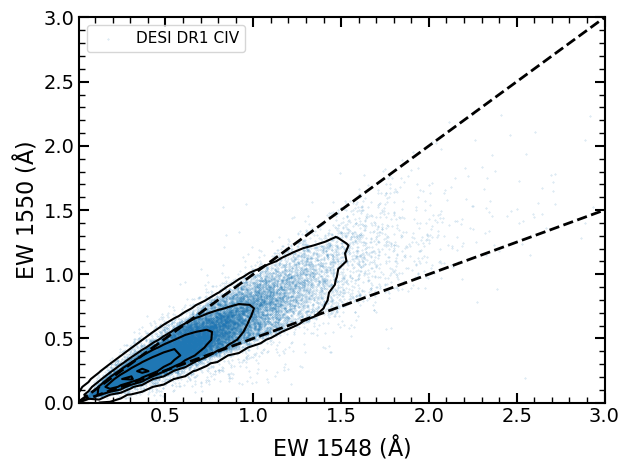

In [8]:
# EW scatter plot

ew1, ew2 = tt["CIV_1548_EW"].data , tt["CIV_1550_EW"].data
xbins = np.linspace(0, 3, 50)
ybins = np.linspace(0, 3, 50)

X, Y, Z, contour_levels = get_contours(ew1, ew2, xbins, ybins)
fig, ax = plt.subplots()
ax.minorticks_on()
cs = ax.contour(X, Y, Z, levels=contour_levels, colors='k', linewidths=1.5, zorder=2)
ax.scatter(ew1, ew2, s=0.1, alpha=0.3, color='C0', label = f'DESI DR1 CIV', rasterized=True)
ax.axline((0,0), slope=1, color='k', ls='--', lw=2)
ax.axline((0,0), slope=0.5, color='k', ls='--', lw=2)
ax.set_xlim(xbins.min()+0.01, xbins.max())
ax.set_ylim(ybins.min(), ybins.max())
ax.set_xlabel('EW 1548 ($\\rm \\AA$)', fontsize=16)
ax.set_ylabel('EW 1550 ($\\rm \\AA$)', fontsize=16)
ax.legend(prop={'size':11})
# Customize tick sizes and font sizes
ax.tick_params(axis='both', which='major', direction='in', top=True, bottom=True, \
               left=True, right=True, length=7, width=1.5, labelsize=14)
ax.tick_params(axis='both', which='minor', direction='in', top=True, bottom=True, \
               left=True, right=True, length=4, width=1, labelsize=10)

# Enable grid with major and minor ticks
#ax.grid(True, which='major', linestyle='-', linewidth='0.75', color='black')
#ax.grid(True, which='minor', linestyle=':', linewidth='0.5', color='gray')

# Set plot boundary thickness
ax.spines['top'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
plt.tight_layout()
plt.show()

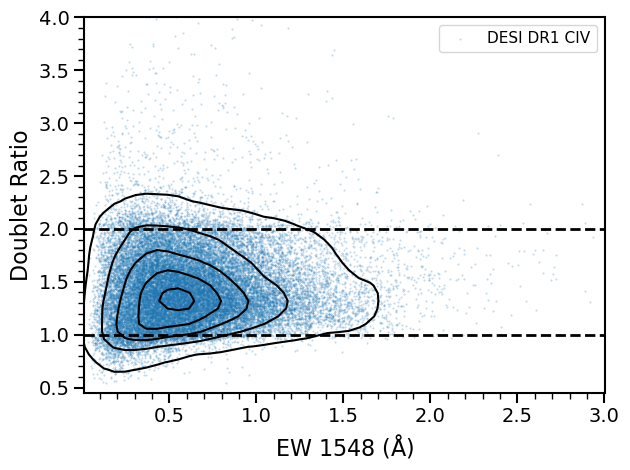

In [9]:
# Doublet Ratio
fig, ax = plt.subplots()
ax.minorticks_on()

x = ew1
y = ew1/ew2

xbins = np.linspace(0, 3, 50)
ybins = np.linspace(0.45, 4, 50)

X, Y, Z, contour_levels = get_contours(x, y, xbins, ybins)
cs = ax.contour(X, Y, Z, levels=contour_levels, colors='k', linewidths=1.5, zorder=2)

ax.scatter(x, y, s=0.2, alpha=0.3, color='C0',  label = f'DESI DR1 CIV', rasterized=True)
ax.axhline(y = 1, color='k', ls='--', lw=2)
ax.axhline(y = 2, color='k', ls='--', lw=2)
ax.set_xlim(xbins.min()+0.01, xbins.max())
ax.set_ylim(ybins.min(), ybins.max())
ax.set_xlabel('EW 1548 ($\\rm \\AA$)', fontsize=16)
ax.set_ylabel('Doublet Ratio', fontsize=16)
ax.legend(prop={'size':11}, loc='upper right')

# Customize tick sizes and font sizes
ax.tick_params(axis='both', which='major', length=7, width=1.5, labelsize=14)
ax.tick_params(axis='both', which='minor', length=4, width=1, labelsize=10)

# Set plot boundary thickness
ax.spines['top'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
plt.tight_layout()
plt.show()

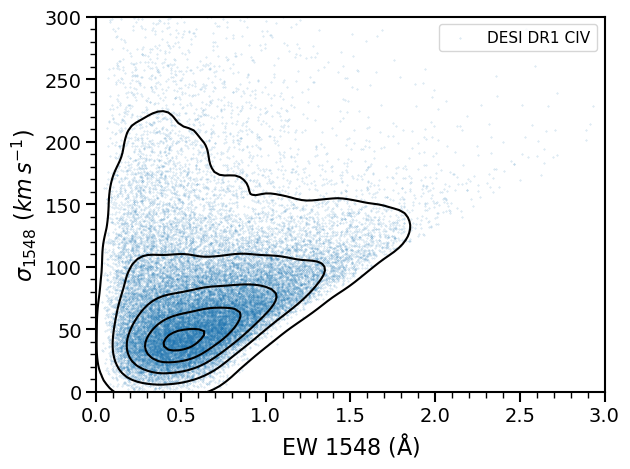

In [10]:
# velocity dispersion
# Fix byte order if needed
x, y = tt["CIV_1548_EW"], tt["CIV_1548_VDISP"]
sel = (0<y)&(y<=350)&(x<=3)
x1, y1 = x[sel], y[sel]
# Create grid
xbins = np.linspace(0, 3, 100)
ybins = np.linspace(0, 300, 100)

X, Y, Z, contour_levels = get_contours(x1, y1, xbins, ybins)
cs = ax.contour(X, Y, Z, levels=contour_levels, colors='k', linewidths=1.5, zorder=2)
Z_masked = np.ma.masked_less(Z, contour_levels[0])  # keep values above 5% contour
fig, ax = plt.subplots()
ax.minorticks_on()
#c = ax.pcolormesh(X, Y, Z_masked, cmap='Oranges', shading='auto', zorder=1)
cs = ax.contour(X, Y, Z, levels=contour_levels, colors='k', linewidths=1.5, zorder=2)
ax.scatter(x1, y1, s=0.1, alpha=0.3, color='C0', label='DESI DR1 CIV', rasterized=True)
ax.set_xlim(0, 3)
ax.set_ylim(0, 300)
ax.set_xlabel('EW 1548 ($\\rm \\AA$)', fontsize=16)
ax.set_ylabel('$\\sigma_{\\rm 1548}$ ($km\,s^{-1}$)', fontsize=16)
ax.legend(prop={'size':11}, loc='upper right')

# Customize tick sizes and font sizes
ax.tick_params(axis='both', which='major', length=7, width=1.5, labelsize=14)
ax.tick_params(axis='both', which='minor', length=4, width=1, labelsize=10)

# Set plot boundary thickness
ax.spines['top'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
plt.tight_layout()

 size of the sample = 32321, percentage of parent sample = 1.0


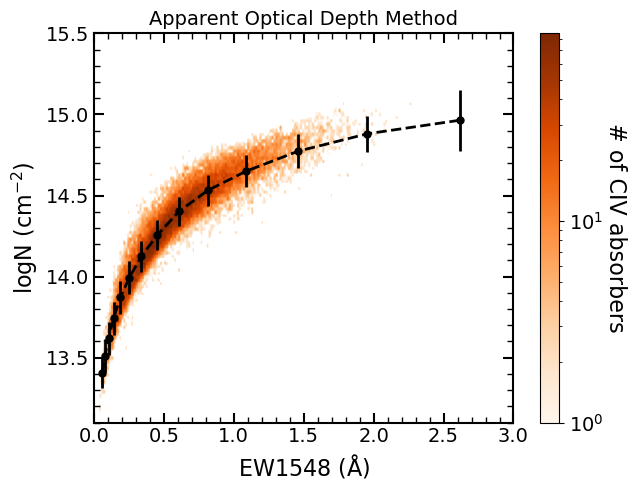

In [11]:
from scipy.stats import binned_statistic
import matplotlib.colors as mcolors
from scipy.ndimage import gaussian_filter
import matplotlib.cm as cm
xbin = np.logspace(np.log10(0.05), np.log10(3), 15)
logNbin = np.logspace(np.log10(12), np.log10(16), 15)
mean_x = xbin[1:]/2 + xbin[:-1]/2
yd = tt["LOG10N"]
density=True
xd = np.copy(ew1)
print(f' size of the sample = {xd.size}, percentage of parent sample = {xd.size/yd.size}')

mean = binned_statistic(xd, values=yd, bins=xbin, statistic='mean')[0]
std = binned_statistic(xd, values=yd, bins=xbin, statistic='std')[0]

fig = plt.figure(figsize=(6.5,5))
ax = fig.add_subplot(111)
plt.minorticks_on()

if not density:
    ax.scatter(xd, yd, s=0.5, alpha=0.1, rasterized=True)
else:

    # Display the density map using imshow
    hist, xedges, yedges = np.histogram2d(xd, yd, bins=(200,100))
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    cmap = plt.cm.Oranges.copy()
    cmap.set_under(color='white')  # Set underflow color to white
    im = ax.imshow(hist.T, origin='lower', aspect='auto', extent=extent, cmap=cmap, norm=mcolors.LogNorm(vmin=1))
    # Color bar
    cbar = plt.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label('# of CIV absorbers', fontsize=16, rotation=270, labelpad = 17)
ax.errorbar(mean_x, mean, yerr=std, color='k', lw=2, marker = 'o', ls = '--', markersize=5)

# Customize tick sizes and font sizes
ax.tick_params(axis='both', which='major', direction='in', top=True, bottom=True, \
               left=True, right=True, length=7, width=1.5, labelsize=14)
ax.tick_params(axis='both', which='minor', direction='in', top=True, bottom=True, \
               left=True, right=True, length=4, width=1, labelsize=10)

# Enable grid with major and minor ticks
#ax.grid(True, which='major', linestyle='-', linewidth='0.75', color='black')
#ax.grid(True, which='minor', linestyle=':', linewidth='0.5', color='gray')

# Set plot boundary thickness
ax.spines['top'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)

ax.set_xlim(0,3)
ax.set_ylim(13.1,15.5)
ax.set_xlabel('EW1548 ($\\rm \\AA$)', fontsize=16)
ax.set_ylabel('logN ($\\rm cm^{-2}$)', fontsize=16)
plt.title('Apparent Optical Depth Method', fontsize=14)
plt.tight_layout()
plt.show()